# Exploring regions that with ambiguously defined ground truths relative to the H37Rv reference genome

### Goal: To summarize the characteristics of regions that are "ambiguous"

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# import gffutils

%matplotlib inline

In [2]:
from Bio import SeqIO

#### Pandas Viewing Settings

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Define function for output of a BED file from a NP array with values for each basepair position

In [4]:
# BED format specifications: https://useast.ensembl.org/info/website/upload/bed.html

def convert_GenomeNParray_To_BED_DF(input_GenomeNParray, genomeChrom = "NC_000962.3"):
    """ """
    last_Score = input_GenomeNParray[0]

    startOfRegion = 0
    listOfBED_Tuples = []
    RegionCounter = 1

    for RefPos_0based in tqdm(np.arange(len(input_GenomeNParray))):

        EBR_Score = input_GenomeNParray[RefPos_0based]

        if EBR_Score != last_Score:

            endOfRegion = RefPos_0based
            lengthOfRegion = endOfRegion - startOfRegion 

            BED_EntryTuple = (genomeChrom, startOfRegion, endOfRegion, f"Region{RegionCounter}_Length_{lengthOfRegion}_bp", last_Score,)
            listOfBED_Tuples.append(BED_EntryTuple)

            RegionCounter += 1

            #print(f"{H37rv_ChrName}, {startOfRegion}, {RefPos_0based}, {lengthOfRegion}_bp, {last_Score}, .")

            startOfRegion = RefPos_0based 

            #1 Output the last range
            #2 Store the new score    

        last_Score = EBR_Score #2 Store the new score   

        
        
    endOfRegion = RefPos_0based + 1
    lengthOfRegion = endOfRegion - startOfRegion 

    BED_EntryTuple = (genomeChrom, startOfRegion, endOfRegion, f"Region{RegionCounter}_Length_{lengthOfRegion}_bp", last_Score)
    listOfBED_Tuples.append(BED_EntryTuple)       

    BED_DF = pd.DataFrame(listOfBED_Tuples)
    
    BED_DF.columns = ["chrom", "chromStart", "chromEnd", "name", "score" ]
    
    
    return BED_DF

# Parse in BED file annotations of H37Rv genome (PLC groups)

In [5]:
RepoRef_Dir = "../../References"
pLC_ExcludedRegionsScheme_RepoRef_Dir = f"{RepoRef_Dir}/pLowConfideceRegions_CoscollaEtAlScheme_Files"


Mtb_H37rv_pLCRegions_Coscolla_BED_PATH = f"{pLC_ExcludedRegionsScheme_RepoRef_Dir}/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedGenes.bed"

Mtb_H37rv_pLCRegions_Coscolla_Subset_PEPPEs_BED_PATH = f"{pLC_ExcludedRegionsScheme_RepoRef_Dir}/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedGenes.PEPPEs.bed"

Mtb_H37rv_pLCRegions_Coscolla_Subset_MGEs_BED_PATH = f"{pLC_ExcludedRegionsScheme_RepoRef_Dir}/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedGenes.MGEs.bed"

Mtb_H37rv_pLCRegions_Coscolla_Subset_RepetitiveGenes_BED_PATH = f"{pLC_ExcludedRegionsScheme_RepoRef_Dir}/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedGenes.RepetitiveGenes.bed"

Mtb_H37rv_pLCRegions_Only_PE_PGRS_And_PPE_MPTR_BED_PATH = f"{pLC_ExcludedRegionsScheme_RepoRef_Dir}/201027_Mtb_H37rv_pLC_Regions_Subset_For_PE_PGRS_And_PPE_MPTR_Only_85_genes.bed"

Mtb_H37rv_pLCRegions_Coscolla_BED_MERGED_PATH = f"{pLC_ExcludedRegionsScheme_RepoRef_Dir}/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedRegion.Merged.bed"

Mtb_H37rv_HighConfidenceRegions_NONCoscollaRegions_BED_PATH = f"{pLC_ExcludedRegionsScheme_RepoRef_Dir}/201027_Mtb_H37rv_HighConfidence_Regions_NONpLC_Regions.bed"


In [6]:
!head $Mtb_H37rv_pLCRegions_Coscolla_BED_PATH

NC_000962.3	33581	33794	Rv0031	Rv0031	InsertionSeqs_And_Phages	None
NC_000962.3	103709	104663	Rv0094c	Rv0094c	InsertionSeqs_And_Phages	None
NC_000962.3	104804	105215	Rv0095c	Rv0095c	InsertionSeqs_And_Phages	None
NC_000962.3	105323	106715	Rv0096	PPE1	PE/PPEs	PPE_SL-2_PPE-PPW
NC_000962.3	131381	132872	Rv0109	PE_PGRS1	PE/PPEs	PE_V_PGRS
NC_000962.3	149532	150996	Rv0124	PE_PGRS2	PE/PPEs	PE_V_PGRS
NC_000962.3	177542	179309	Rv0151c	PE1	PE/PPEs	PE_V_
NC_000962.3	179318	180896	Rv0152c	PE2	PE/PPEs	PE_V_
NC_000962.3	187432	188839	Rv0159c	PE3	PE/PPEs	PE_V_
NC_000962.3	188930	190439	Rv0160c	PE4	PE/PPEs	PE_V_


## Parse Assembly and Sequence analysis results Sample Info

In [7]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary


SampleIDs_36CI_SOI = list( PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].values )


print(','.join(SampleIDs_36CI_SOI) )

# Make sample to metadata mapping dicts

ID_To_IlluminaAvrgCov_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'Dataset_Tag']].values)

M0011368_9,M0014888_3,M0016395_7,M0010874_7,01_R1430,02_R0894,02_R1708,02_R1896,M0016737_0,M0017522_5,01_R1134,M0003941_3,02_R1179,N1176,N0072,N0153,N0145,N0155,N0004,N1274,N0054,N1272,N0091,N1202,N1177,RW-TB008,DNA028,DNA075,DNA091,DNA044,DNA020,AZE_02_042,DNA019_Rose,DNA120,DNA188,DNA086


# 0) Read in pickles of processed data

## Read back in EBR NPY arrays 

In [8]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

# Define directory for EBR analysis data
PBvIll_EBR_Dir = PB_Vs_Illumina_DataAnalysis_Dir + "/210112_EBR_H37rv_36CI_MM2vsPilon_V7"         

PBvsIll_EBR_IndivSample_NPZs = f"{PBvIll_EBR_Dir}/210112_EBR_H37rv_IndividualSampleRecall_NPZs"


# Parse in aggregated EBR-36CI array
EBR_36CI_WGS40X_NPZ_PATH = f"{PBvIll_EBR_Dir}/210112_EBR_V7_36CI.npz"

EBR_36CI_Array_A4 = np.load(EBR_36CI_WGS40X_NPZ_PATH)["arr_0"]



# Parse in individual EBR arrays for each isolate and store in dictionary
dictOf_EBR_IndivIsolate_NPYs= {}

for SampleID in tqdm(SampleIDs_36CI_SOI):
    
    i_EBR_Agreement_NPZ_PATH = f"{PBvsIll_EBR_IndivSample_NPZs}/EBR.V7.IndivIsolate.{SampleID}.npz"

    i_EBR_NP = np.load(i_EBR_Agreement_NPZ_PATH)["arr_0"]

    dictOf_EBR_IndivIsolate_NPYs[SampleID] = i_EBR_NP


100%|██████████| 36/36 [00:06<00:00,  4.96it/s]


In [9]:
dictOf_EBR_IndivIsolate_NPYs.keys()

dict_keys(['M0011368_9', 'M0014888_3', 'M0016395_7', 'M0010874_7', '01_R1430', '02_R0894', '02_R1708', '02_R1896', 'M0016737_0', 'M0017522_5', '01_R1134', 'M0003941_3', '02_R1179', 'N1176', 'N0072', 'N0153', 'N0145', 'N0155', 'N0004', 'N1274', 'N0054', 'N1272', 'N0091', 'N1202', 'N1177', 'RW-TB008', 'DNA028', 'DNA075', 'DNA091', 'DNA044', 'DNA020', 'AZE_02_042', 'DNA019_Rose', 'DNA120', 'DNA188', 'DNA086'])

# Let's define AMB regions for the EBR-36CI calculation (> 25% N/A)

In [10]:
i_EBR_Array = pd.Series(EBR_36CI_Array_A4).fillna("Ambiguous").values

EBR_36CI_BED_DF = convert_GenomeNParray_To_BED_DF(i_EBR_Array)

EBR_36CI_BED_DF["Length"] = EBR_36CI_BED_DF["chromEnd"] - EBR_36CI_BED_DF["chromStart"]      

EBR_36CI_BED_DF_AMB_ONLY = EBR_36CI_BED_DF[ EBR_36CI_BED_DF["score"] == "Ambiguous" ]

100%|██████████| 4411532/4411532 [00:04<00:00, 988760.46it/s] 


### What % of the genome had high levels of ambiguouity in EBR analysis? (> 25% of isolates with Amb at position) 

#### Answer: 0.35% (15,813 bp of the genome, largely in MGEs)

In [11]:
EBR_36CI_BED_DF_AMB_ONLY["Length"].sum()

15813

In [12]:
(EBR_36CI_BED_DF_AMB_ONLY["Length"].sum() / 4411532) * 100

0.35844690687951486

# Output AMB Regions (Individual & Aggregated Levels)

In [13]:
# Define directory for analysis

PBvIll_EBR_Ambigous_RegionsDir = f"{PBvIll_EBR_Dir}/EBR_36CI_AmbigousRegions"

!mkdir $PBvIll_EBR_Ambigous_RegionsDir


mkdir: cannot create directory ‘../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI/210112_EBR_H37rv_36CI_MM2vsPilon_V7/EBR_36CI_AmbigousRegions’: File exists


## A) Ouput AMB regions from the aggregated EBR-36CI score

In [14]:
EBR_36CI_Ambigous_Regions_BED_PATH = f"{PBvIll_EBR_Ambigous_RegionsDir}/EBR_36CI_AmbigousRegions_V1.bed"
EBR_36CI_Ambigous_Regions_WithHeader_BED_PATH = f"{PBvIll_EBR_Ambigous_RegionsDir}/EBR_36CI_AmbigousRegions_V1.WithHeader.bed.tsv"


EBR_36CI_BED_DF_AMB_ONLY.to_csv(EBR_36CI_Ambigous_Regions_BED_PATH,
                           sep = "\t",
                           index = False,
                           header = False)


EBR_36CI_BED_DF_AMB_ONLY.to_csv(EBR_36CI_Ambigous_Regions_WithHeader_BED_PATH,
                           sep = "\t",
                           index = False,
                           header = True)



In [15]:
!ls -lah $PBvIll_EBR_Ambigous_RegionsDir

total 184K
drwxrwsr-x 2 mm774 farhat  188 Mar 26 14:49 .
drwxrwsr-x 4 mm774 farhat  269 Mar 26 14:46 ..
-rw-rw-r-- 1 mm774 farhat 1.6K Mar 26 16:19 EBR_36CI_AmbigousRegions_V1.bed
-rw-rw-r-- 1 mm774 farhat 1.7K Mar 26 16:19 EBR_36CI_AmbigousRegions_V1.WithHeader.bed.tsv
-rw-rw-r-- 1 mm774 farhat  72K Mar 26 14:49 Mtb_AmbigouslyDefinedRegions_PerIsolate_V1.WithHeader.bed


In [16]:
EBR_36CI_BED_DF.shape

(21613, 6)

In [17]:
EBR_36CI_BED_DF_AMB_ONLY.shape

(24, 6)

In [18]:
EBR_36CI_BED_DF_AMB_ONLY.head(5)

,chrom,chromStart,chromEnd,name,score,Length
995,NC_000962.3,334641,334653,Region996_Length_12_bp,Ambiguous,12
997,NC_000962.3,334694,334723,Region998_Length_29_bp,Ambiguous,29
4251,NC_000962.3,888762,889020,Region4252_Length_258_bp,Ambiguous,258
4253,NC_000962.3,889033,890373,Region4254_Length_1340_bp,Ambiguous,1340
5513,NC_000962.3,1093947,1094062,Region5514_Length_115_bp,Ambiguous,115


In [19]:
!wc -l $EBR_36CI_Ambigous_Regions_BED_PATH

24 ../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI/210112_EBR_H37rv_36CI_MM2vsPilon_V7/EBR_36CI_AmbigousRegions/EBR_36CI_AmbigousRegions_V1.bed


In [20]:
!wc -l $Mtb_H37rv_pLCRegions_Coscolla_Subset_PEPPEs_BED_PATH

168 ../../References/pLowConfideceRegions_CoscollaEtAlScheme_Files/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedGenes.PEPPEs.bed


In [21]:
!wc -l $Mtb_H37rv_pLCRegions_Coscolla_Subset_MGEs_BED_PATH

147 ../../References/pLowConfideceRegions_CoscollaEtAlScheme_Files/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedGenes.MGEs.bed


In [22]:
!wc -l $Mtb_H37rv_pLCRegions_Coscolla_Subset_RepetitiveGenes_BED_PATH

69 ../../References/pLowConfideceRegions_CoscollaEtAlScheme_Files/201027_Mtb_H37rv_pLC_Regions_CoscollaExcludedGenes.RepetitiveGenes.bed


In [23]:
#!bedtools coverage -a $EBR_36CI_Ambigous_Regions_BED_PATH -b $Mtb_H37rv_pLCRegions_Coscolla_BED_MERGED_PATH

In [24]:
#!bedtools coverage -a $EBR_36CI_Ambigous_Regions_BED_PATH -b $Mtb_H37rv_pLCRegions_Coscolla_Subset_MGEs_BED_PATH

In [25]:
#!bedtools coverage -a $EBR_36CI_Ambigous_Regions_BED_PATH -b $Mtb_H37rv_pLCRegions_Coscolla_Subset_PEPPEs_BED_PATH

In [26]:
#!bedtools coverage -a $EBR_36CI_Ambigous_Regions_BED_PATH -b $Mtb_H37rv_pLCRegions_Coscolla_Subset_RepetitiveGenes_BED_PATH

In [27]:
15813 - 262

15551

In [28]:
15551/15813

0.9834313539492823

## Evaluate coverage of all 3 PLC subcategories with AMB regions
A total of 262 bp were from regions which didn't overlap with regions that were already part of the PLC regions


In [29]:
!bedtools coverage -a $EBR_36CI_Ambigous_Regions_BED_PATH -b $Mtb_H37rv_pLCRegions_Coscolla_Subset_PEPPEs_BED_PATH $Mtb_H37rv_pLCRegions_Coscolla_Subset_MGEs_BED_PATH $Mtb_H37rv_pLCRegions_Coscolla_Subset_RepetitiveGenes_BED_PATH

NC_000962.3	334641	334653	Region996_Length_12_bp	Ambiguous	12	1	12	12	1.0000000
NC_000962.3	334694	334723	Region998_Length_29_bp	Ambiguous	29	1	29	29	1.0000000
NC_000962.3	888762	889020	Region4252_Length_258_bp	Ambiguous	258	0	0	258	0.0000000
NC_000962.3	889033	890373	Region4254_Length_1340_bp	Ambiguous	1340	2	1262	1340	0.9417911
NC_000962.3	1093947	1094062	Region5514_Length_115_bp	Ambiguous	115	1	115	115	1.0000000
NC_000962.3	1480948	1481670	Region7844_Length_722_bp	Ambiguous	722	1	722	722	1.0000000
NC_000962.3	1541951	1543304	Region8088_Length_1353_bp	Ambiguous	1353	2	1262	1353	0.9327421
NC_000962.3	1637087	1637214	Region8717_Length_127_bp	Ambiguous	127	1	127	127	1.0000000
NC_000962.3	1987702	1989057	Region9675_Length_1355_bp	Ambiguous	1355	2	1262	1355	0.9313653
NC_000962.3	1996100	1997452	Region9810_Length_1352_bp	Ambiguous	1352	3	1297	1352	0.9593195
NC_000962.3	2268721	2268725	Region11088_Length_4_bp	Ambiguous	4	0	0	4	0.0000000
NC_000962.3	2550013	2551366	Region12413_Length_1353_bp

In [1]:
258 + 4 + 250 

512

In [2]:
512 / 15813

0.032378422816669826

In [3]:
(15813 - 512) / 15813

0.9676215771833302

# Let's parse and output BED files for all of the "Ambigous Regions" for each sample 

In [30]:
### Step 1: Parse all Ambigous Regions to a BED file formatted Pandas DF
### Step 2: Output the AmbRegions to a BED  

### Define directories of PMP-SM pipeline

In [31]:
# Define varaint calling pipeline output directories

PacBio_ProjectDir = "/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project"
PMP_SM_Outputs_Dir = PacBio_ProjectDir + "/PacmanPipe_SM_Outputs"
PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir = PMP_SM_Outputs_Dir + "/201201_PMP_SM_TB_Portals_R1_Output_V2"      


In [32]:
dictOf_EBR_IndivIsolate_NPYs.keys()

dict_keys(['M0011368_9', 'M0014888_3', 'M0016395_7', 'M0010874_7', '01_R1430', '02_R0894', '02_R1708', '02_R1896', 'M0016737_0', 'M0017522_5', '01_R1134', 'M0003941_3', '02_R1179', 'N1176', 'N0072', 'N0153', 'N0145', 'N0155', 'N0004', 'N1274', 'N0054', 'N1272', 'N0091', 'N1202', 'N1177', 'RW-TB008', 'DNA028', 'DNA075', 'DNA091', 'DNA044', 'DNA020', 'AZE_02_042', 'DNA019_Rose', 'DNA120', 'DNA188', 'DNA086'])

## Files to save:

1) Save a BED file each for sampleID's ambigous regions <br>
1) Save a BED-TSV file each for EBR-36CI ambigous regions (Ambigous across > 25% of isolates) <br>


### Define directories of Snakemake pipeline output

In [33]:
# Define varaint calling pipeline output directories

PacBio_ProjectDir = "/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project"
PMP_SM_Outputs_Dir = PacBio_ProjectDir + "/PacmanPipe_SM_Outputs"
PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir = PMP_SM_Outputs_Dir + "/201201_PMP_SM_TB_Portals_R1_Output_V2"      


In [34]:
listOf_AmbRegions_DFs = []

for SampleID in tqdm(SampleIDs_36CI_SOI): # tqdm( ["M0011368_9"])
    
    #print(f"{sample_Counter} - Sample: {SampleID}")
    #SampleID = "M0011368_9"

    Sample_Output_Dir = PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir + "/" + SampleID

    EBR_Ambigous_Regions_OutputDir = f"{Sample_Output_Dir}/VariantCallingVersusH37Rv/EBR_Analysis_PB_MM2_AmbigousRegions"
    
    #!mkdir $EBR_Ambigous_Regions_OutputDir
    
    # EBR_Ambigous_Regions_BED_PATH = f"{EBR_Ambigous_Regions_OutputDir}/{SampleID}.EBR.V7.Amb.Regions.bed"
    
    
    #i_EBR_BED_DF = dictOf_BED_DFs_IndivSample_EBRs.get(SampleID, Sample_EBR_N0153_DF[ Sample_EBR_N0153_DF["score"] == "NotReal" ] )   
    #i_EBR_BED_DF = dictOf_BED_DFs_IndivSample_EBRs[SampleID]

    i_EBR_BED_DF = convert_GenomeNParray_To_BED_DF( pd.Series(dictOf_EBR_IndivIsolate_NPYs[SampleID]).fillna("Ambiguous").values )   

    
    
    i_EBR_BED_DF_AMB_ONLY = i_EBR_BED_DF[ i_EBR_BED_DF["score"] == "Ambiguous" ]

    
    i_EBR_BED_DF_AMB_ONLY["SampleID"] = SampleID
    
    listOf_AmbRegions_DFs.append( i_EBR_BED_DF_AMB_ONLY )
    
    

100%|██████████| 4411532/4411532 [00:04<00:00, 933802.05it/s]/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 36/36 [02:55<00:00,  2.97s/it]1885678.62it/s]


In [35]:
listOf_AmbRegions_DFs[0].shape

(21, 6)

In [36]:
All_EBR_AmbRegions_ForEach_36CI_DF = pd.concat(listOf_AmbRegions_DFs)
All_EBR_AmbRegions_ForEach_36CI_DF["Length"] = All_EBR_AmbRegions_ForEach_36CI_DF["chromEnd"]  -  All_EBR_AmbRegions_ForEach_36CI_DF["chromStart"]





In [37]:
All_EBR_AmbRegions_ForEach_36CI_DF.shape

(994, 7)

In [38]:
All_EBR_AmbRegions_ForEach_36CI_DF.head()

,chrom,chromStart,chromEnd,name,score,SampleID,Length
67,NC_000962.3,334694,334723,Region68_Length_29_bp,Ambiguous,M0011368_9,29
221,NC_000962.3,888762,889020,Region222_Length_258_bp,Ambiguous,M0011368_9,258
224,NC_000962.3,890379,890450,Region225_Length_71_bp,Ambiguous,M0011368_9,71
280,NC_000962.3,1074324,1074327,Region281_Length_3_bp,Ambiguous,M0011368_9,3
296,NC_000962.3,1093947,1094062,Region297_Length_115_bp,Ambiguous,M0011368_9,115


In [39]:
All_EBR_AmbRegions_ForEach_36CI_DF[All_EBR_AmbRegions_ForEach_36CI_DF["SampleID"] == "N0072"].sort_values("chromStart").head(5)

,chrom,chromStart,chromEnd,name,score,SampleID,Length
20,NC_000962.3,334641,334653,Region21_Length_12_bp,Ambiguous,N0072,12
192,NC_000962.3,888762,889020,Region193_Length_258_bp,Ambiguous,N0072,258
233,NC_000962.3,1093947,1094062,Region234_Length_115_bp,Ambiguous,N0072,115
254,NC_000962.3,1190171,1190175,Region255_Length_4_bp,Ambiguous,N0072,4
303,NC_000962.3,1414948,1415887,Region304_Length_939_bp,Ambiguous,N0072,939


In [40]:
All_EBR_AmbRegions_ForEach_36CI_DF[All_EBR_AmbRegions_ForEach_36CI_DF["SampleID"] == "RW-TB008"].sort_values("Length").head(5)

,chrom,chromStart,chromEnd,name,score,SampleID,Length
451,NC_000962.3,2268721,2268725,Region452_Length_4_bp,Ambiguous,RW-TB008,4
359,NC_000962.3,1981814,1981819,Region360_Length_5_bp,Ambiguous,RW-TB008,5
472,NC_000962.3,2366969,2366975,Region473_Length_6_bp,Ambiguous,RW-TB008,6
42,NC_000962.3,334641,334653,Region43_Length_12_bp,Ambiguous,RW-TB008,12
694,NC_000962.3,3732552,3732570,Region695_Length_18_bp,Ambiguous,RW-TB008,18


In [41]:
All_EBR_AmbRegions_ForEach_36CI_DF.sort_values("Length").head(2)

,chrom,chromStart,chromEnd,name,score,SampleID,Length
532,NC_000962.3,1987701,1987702,Region533_Length_1_bp,Ambiguous,M0016395_7,1
509,NC_000962.3,3501664,3501665,Region510_Length_1_bp,Ambiguous,DNA044,1


(array([606., 154., 165.,  13.,  14.,  13.,   7.,   8.,   4.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   3.,
          0.,   1.,   1.]),
 array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
         4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
         9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500]),
 <a list of 25 Patch objects>)

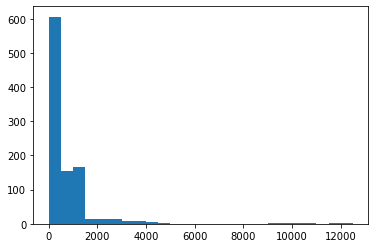

In [42]:
plt.hist(All_EBR_AmbRegions_ForEach_36CI_DF["Length"], bins = np.arange(0, 13000, 500))

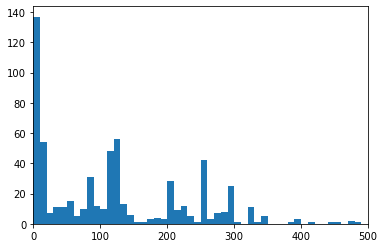

In [43]:
plt.hist(All_EBR_AmbRegions_ForEach_36CI_DF["Length"], bins = np.arange(0, 13000, 10))

plt.xlim(0,500)
plt.show()

# Output AMB regions for all 36 individual isolates in 1 table

In [44]:
All_EBR_AmbRegions_ForEach_36CI_DF.head()

,chrom,chromStart,chromEnd,name,score,SampleID,Length
67,NC_000962.3,334694,334723,Region68_Length_29_bp,Ambiguous,M0011368_9,29
221,NC_000962.3,888762,889020,Region222_Length_258_bp,Ambiguous,M0011368_9,258
224,NC_000962.3,890379,890450,Region225_Length_71_bp,Ambiguous,M0011368_9,71
280,NC_000962.3,1074324,1074327,Region281_Length_3_bp,Ambiguous,M0011368_9,3
296,NC_000962.3,1093947,1094062,Region297_Length_115_bp,Ambiguous,M0011368_9,115


In [45]:
EBR_Ambigously_Regions_PerIsolate_BED_PATH = f"{PBvIll_EBR_Ambigous_RegionsDir}/Mtb_AmbigouslyDefinedRegions_PerIsolate_V1.bed"
EBR_Ambigously_Regions_PerIsolate_WiHeader_BED_PATH = f"{PBvIll_EBR_Ambigous_RegionsDir}/Mtb_AmbigouslyDefinedRegions_PerIsolate_V1.WithHeader.bed"


All_EBR_AmbRegions_ForEach_36CI_DF.to_csv(EBR_Ambigously_Regions_PerIsolate_WiHeader_BED_PATH,
                           sep = "\t",
                           index = False,
                           header = True)



In [46]:
!ls -lah $PBvIll_EBR_Ambigous_RegionsDir

total 184K
drwxrwsr-x 2 mm774 farhat  188 Mar 26 14:49 .
drwxrwsr-x 4 mm774 farhat  269 Mar 26 14:46 ..
-rw-rw-r-- 1 mm774 farhat 1.6K Mar 26 16:19 EBR_36CI_AmbigousRegions_V1.bed
-rw-rw-r-- 1 mm774 farhat 1.7K Mar 26 16:19 EBR_36CI_AmbigousRegions_V1.WithHeader.bed.tsv
-rw-rw-r-- 1 mm774 farhat  72K Mar 26 16:22 Mtb_AmbigouslyDefinedRegions_PerIsolate_V1.WithHeader.bed


## Parse % of genome that Amb regions make up (On Per Isolate Basis)

In [47]:
sample_Counter = 1

dictOf_SampleID_To_PercentOfGenomeAMB = {}

for SampleID in (SampleIDs_36CI_SOI): # tqdm( ["M0011368_9"])
#for SampleID in tqdm(SampleIDs_35CI_AllSamples): # tqdm( ["M0011368_9"])

    
    print(f"{sample_Counter} - Sample: {SampleID}")
    #SampleID = "M0011368_9"

    Sample_Output_Dir = PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir + "/" + SampleID

    EBR_Ambigous_Regions_OutputDir = f"{Sample_Output_Dir}/EmpiricalBasePairRecall_Analysis_V7_PacBio_Vs_IlluminaPilon"
    
    #!mkdir $EBR_Ambigous_Regions_OutputDir
    
    EBR_Ambigous_Regions_BED_PATH = f"{EBR_Ambigous_Regions_OutputDir}/EBR.V7.IndivIsolate.{SampleID}.Ambiguous.Regions.bed"
    #EBR_Ambigous_Regions_HighSeqDivergence_BED_PATH = f"{EBR_Ambigous_Regions_OutputDir}/EBR.V7.IndivIsolate.{SampleID}.Ambiguous.NoDupRegions.HighSeqDivergenceOnly.Regions.bed"
    #EBR_Ambigous_Regions_DUPregions_BED_PATH = f"{EBR_Ambigous_Regions_OutputDir}/EBR.V7.IndivIsolate.{SampleID}.Ambiguous.DupRegions.Regions.bed"

    
    Total_Num_AmbRegions = !wc -l $EBR_Ambigous_Regions_BED_PATH
    Total_Num_AmbRegions = int(Total_Num_AmbRegions[0].split(" ")[0])

    Num_AmbRegions_OverlapWithPLC = !bedtools intersect -a $EBR_Ambigous_Regions_BED_PATH -b $Mtb_H37rv_pLCRegions_Coscolla_BED_PATH -wa | bedtools merge | wc -l
    Num_AmbRegions_OverlapWithPLC = int(Num_AmbRegions_OverlapWithPLC[0].split(" ")[0])
  
    i_FractionOf_AmbRegions_OverlapWithPLC = Num_AmbRegions_OverlapWithPLC / Total_Num_AmbRegions

    print( i_FractionOf_AmbRegions_OverlapWithPLC)
    
    
    
    #i_EBR_BED_DF = dictOf_BED_DFs_IndivSample_EBRs[SampleID]

    
    
    
    i_EBR_BED_DF = convert_GenomeNParray_To_BED_DF( pd.Series(dictOf_EBR_IndivIsolate_NPYs[SampleID]).fillna("Ambiguous").values )     

    i_EBR_BED_DF_AMB_ONLY = i_EBR_BED_DF[ i_EBR_BED_DF["score"] == "Ambiguous" ]
    
    
    
    i_EBR_BED_DF_AMB_ONLY["Length"] = i_EBR_BED_DF_AMB_ONLY["chromEnd"] - i_EBR_BED_DF_AMB_ONLY["chromStart"]

    
    Percent_NA_i = float(  ( (i_EBR_BED_DF_AMB_ONLY["Length"].values.astype(int).sum()) / 4411532) * 100 )
    
    dictOf_SampleID_To_PercentOfGenomeAMB[SampleID] = Percent_NA_i
    
    print("% of genome w/ N/A for EBR:", Percent_NA_i)   
    
    
    #!ls -lah $EBR_Ambigous_Regions_BED_PATH 
    #!wc -l $EBR_Ambigous_Regions_BED_PATH 
    #!head -n 3 $EBR_Ambigous_Regions_BED_PATH 
    
    print()
    sample_Counter += 1
    
    
    

1 - Sample: M0011368_9
0.7142857142857143


100%|██████████| 4411532/4411532 [00:02<00:00, 2011334.32it/s]


% of genome w/ N/A for EBR: 0.2539480615804215

2 - Sample: M0014888_3


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.8888888888888888


100%|██████████| 4411532/4411532 [00:02<00:00, 1760201.62it/s]


% of genome w/ N/A for EBR: 0.25127325382656185

3 - Sample: M0016395_7
0.52


100%|██████████| 4411532/4411532 [00:02<00:00, 1972683.15it/s]

% of genome w/ N/A for EBR: 0.19997588139449063

4 - Sample: M0010874_7


0.6666666666666666


100%|██████████| 4411532/4411532 [00:02<00:00, 1992808.68it/s]

% of genome w/ N/A for EBR: 0.4823947780498929

5 - Sample: 01_R1430


0.6190476190476191


100%|██████████| 4411532/4411532 [00:02<00:00, 1858282.97it/s]


% of genome w/ N/A for EBR: 0.3044067231066214

6 - Sample: 02_R0894
0.7619047619047619


100%|██████████| 4411532/4411532 [00:02<00:00, 1990230.72it/s]

% of genome w/ N/A for EBR: 0.21763414614242851

7 - Sample: 02_R1708


0.7142857142857143


100%|██████████| 4411532/4411532 [00:02<00:00, 1994582.42it/s]

% of genome w/ N/A for EBR: 0.21743013538154093

8 - Sample: 02_R1896


0.8636363636363636


100%|██████████| 4411532/4411532 [00:02<00:00, 1970099.69it/s]


% of genome w/ N/A for EBR: 0.3811374370626803

9 - Sample: M0016737_0
0.7916666666666666


100%|██████████| 4411532/4411532 [00:02<00:00, 2001443.63it/s]

% of genome w/ N/A for EBR: 0.44805296663381333

10 - Sample: M0017522_5


0.8571428571428571


100%|██████████| 4411532/4411532 [00:02<00:00, 1993961.03it/s]

% of genome w/ N/A for EBR: 0.4330468417774143

11 - Sample: 01_R1134


0.8235294117647058


100%|██████████| 4411532/4411532 [00:02<00:00, 1990316.56it/s]

% of genome w/ N/A for EBR: 0.26732210034971976

12 - Sample: M0003941_3


0.6388888888888888


100%|██████████| 4411532/4411532 [00:02<00:00, 2000919.43it/s]

% of genome w/ N/A for EBR: 0.4084748790216188

13 - Sample: 02_R1179


0.6818181818181818


100%|██████████| 4411532/4411532 [00:02<00:00, 1987061.53it/s]

% of genome w/ N/A for EBR: 0.23798988650654695

14 - Sample: N1176


0.6857142857142857


100%|██████████| 4411532/4411532 [00:02<00:00, 1985274.72it/s]

% of genome w/ N/A for EBR: 0.4899885119273758

15 - Sample: N0072


0.7407407407407407


100%|██████████| 4411532/4411532 [00:02<00:00, 1988338.20it/s]

% of genome w/ N/A for EBR: 0.2685461649150454

16 - Sample: N0153


0.6923076923076923


100%|██████████| 4411532/4411532 [00:02<00:00, 1981464.97it/s]

% of genome w/ N/A for EBR: 0.650658320057522

17 - Sample: N0145


0.6666666666666666


100%|██████████| 4411532/4411532 [00:02<00:00, 1999560.43it/s]

% of genome w/ N/A for EBR: 0.49010185123898

18 - Sample: N0155


0.6666666666666666


100%|██████████| 4411532/4411532 [00:02<00:00, 1993658.75it/s]

% of genome w/ N/A for EBR: 0.5419432523667514

19 - Sample: N0004


0.7714285714285715


100%|██████████| 4411532/4411532 [00:02<00:00, 1947633.83it/s]


% of genome w/ N/A for EBR: 0.4317547736251261

20 - Sample: N1274
0.7647058823529411


100%|██████████| 4411532/4411532 [00:02<00:00, 1951695.65it/s]

% of genome w/ N/A for EBR: 0.45156648529354426

21 - Sample: N0054


0.7714285714285715


100%|██████████| 4411532/4411532 [00:02<00:00, 2004683.66it/s]

% of genome w/ N/A for EBR: 0.4481209702207759

22 - Sample: N1272


0.6875


100%|██████████| 4411532/4411532 [00:02<00:00, 1996681.17it/s]

% of genome w/ N/A for EBR: 0.4935473663117484

23 - Sample: N0091


0.6666666666666666


100%|██████████| 4411532/4411532 [00:02<00:00, 1999204.38it/s]

% of genome w/ N/A for EBR: 0.6953593445542274

24 - Sample: N1202


0.7241379310344828


100%|██████████| 4411532/4411532 [00:02<00:00, 1983290.21it/s]

% of genome w/ N/A for EBR: 0.6635563337180825

25 - Sample: N1177


0.6774193548387096


100%|██████████| 4411532/4411532 [00:02<00:00, 1986290.85it/s]

% of genome w/ N/A for EBR: 0.6417271823031092

26 - Sample: RW-TB008


0.8214285714285714


100%|██████████| 4411532/4411532 [00:02<00:00, 1993547.48it/s]

% of genome w/ N/A for EBR: 0.7857361116274346

27 - Sample: DNA028


0.5952380952380952


100%|██████████| 4411532/4411532 [00:02<00:00, 1992214.99it/s]

% of genome w/ N/A for EBR: 0.5260304130175186

28 - Sample: DNA075


0.5714285714285714


100%|██████████| 4411532/4411532 [00:02<00:00, 2006472.73it/s]


% of genome w/ N/A for EBR: 0.40457600670243354

29 - Sample: DNA091
0.5833333333333334


100%|██████████| 4411532/4411532 [00:02<00:00, 2015021.13it/s]


% of genome w/ N/A for EBR: 0.41946879224722844

30 - Sample: DNA044
0.71875


100%|██████████| 4411532/4411532 [00:02<00:00, 1965296.13it/s]


% of genome w/ N/A for EBR: 0.28677112622100437

31 - Sample: DNA020
0.7142857142857143


100%|██████████| 4411532/4411532 [00:02<00:00, 2011556.04it/s]


% of genome w/ N/A for EBR: 0.2756638736837906

32 - Sample: AZE_02_042
0.6923076923076923


100%|██████████| 4411532/4411532 [00:02<00:00, 1957319.48it/s]


% of genome w/ N/A for EBR: 0.3742917426417852

33 - Sample: DNA019_Rose
0.8461538461538461


100%|██████████| 4411532/4411532 [00:02<00:00, 1950475.66it/s]


% of genome w/ N/A for EBR: 0.3408113099938978

34 - Sample: DNA120
0.75


100%|██████████| 4411532/4411532 [00:02<00:00, 1997672.78it/s]

% of genome w/ N/A for EBR: 0.31605800433953557

35 - Sample: DNA188


0.8636363636363636


100%|██████████| 4411532/4411532 [00:02<00:00, 1707826.36it/s]


% of genome w/ N/A for EBR: 0.42731187261024056

36 - Sample: DNA086
0.5555555555555556


100%|██████████| 4411532/4411532 [00:02<00:00, 1991191.93it/s]

% of genome w/ N/A for EBR: 0.29998648995405675



In [48]:
!bedtools intersect -a $EBR_Ambigous_Regions_BED_PATH -b $Mtb_H37rv_pLCRegions_Coscolla_BED_PATH -wa

NC_000962.3	334641	334653	Region46_Length_12_bp	Ambiguous
NC_000962.3	1093947	1094062	Region349_Length_115_bp	Ambiguous
NC_000962.3	1096042	1096157	Region351_Length_115_bp	Ambiguous
NC_000962.3	1637087	1637214	Region466_Length_127_bp	Ambiguous
NC_000962.3	1996098	1997461	Region503_Length_1363_bp	Ambiguous
NC_000962.3	1996098	1997461	Region503_Length_1363_bp	Ambiguous
NC_000962.3	1996098	1997461	Region503_Length_1363_bp	Ambiguous
NC_000962.3	2306452	2306724	Region568_Length_272_bp	Ambiguous
NC_000962.3	2550013	2551366	Region618_Length_1353_bp	Ambiguous
NC_000962.3	2550013	2551366	Region618_Length_1353_bp	Ambiguous
NC_000962.3	2550013	2551366	Region618_Length_1353_bp	Ambiguous
NC_000962.3	2632922	2634201	Region627_Length_1279_bp	Ambiguous
NC_000962.3	2635576	2636375	Region635_Length_799_bp	Ambiguous
NC_000962.3	2635576	2636375	Region635_Length_799_bp	Ambiguous
NC_000962.3	2635576	2636375	Region635_Length_799_bp	Ambiguous
NC_000962.3	2638985	2639613	Region638_Length_628_bp	Ambiguous
NC_00

In [49]:
i_EBR_BED_DF_AMB_ONLY["Length"].values.astype(int).sum()

13234

In [50]:
i_EBR_BED_DF["score"].value_counts()

1.0          495
0.0          483
Ambiguous     27
Name: score, dtype: int64

In [51]:
dictOf_SampleID_To_PercentOfGenomeAMB

{'M0011368_9': 0.2539480615804215,
 'M0014888_3': 0.25127325382656185,
 'M0016395_7': 0.19997588139449063,
 'M0010874_7': 0.4823947780498929,
 '01_R1430': 0.3044067231066214,
 '02_R0894': 0.21763414614242851,
 '02_R1708': 0.21743013538154093,
 '02_R1896': 0.3811374370626803,
 'M0016737_0': 0.44805296663381333,
 'M0017522_5': 0.4330468417774143,
 '01_R1134': 0.26732210034971976,
 'M0003941_3': 0.4084748790216188,
 '02_R1179': 0.23798988650654695,
 'N1176': 0.4899885119273758,
 'N0072': 0.2685461649150454,
 'N0153': 0.650658320057522,
 'N0145': 0.49010185123898,
 'N0155': 0.5419432523667514,
 'N0004': 0.4317547736251261,
 'N1274': 0.45156648529354426,
 'N0054': 0.4481209702207759,
 'N1272': 0.4935473663117484,
 'N0091': 0.6953593445542274,
 'N1202': 0.6635563337180825,
 'N1177': 0.6417271823031092,
 'RW-TB008': 0.7857361116274346,
 'DNA028': 0.5260304130175186,
 'DNA075': 0.40457600670243354,
 'DNA091': 0.41946879224722844,
 'DNA044': 0.28677112622100437,
 'DNA020': 0.2756638736837906,
 

In [52]:
PMP_36CI_AnalysisSet_AssemblySummary["Percent_Amb_RelativeToH37Rv"] = PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].map(dictOf_SampleID_To_PercentOfGenomeAMB)

In [53]:
PMP_36CI_AnalysisSet_AssemblySummary["Percent_Amb_RelativeToH37Rv"].describe()

count    36.000000
mean      0.411852
std       0.148348
min       0.199976
25%       0.283994
50%       0.413972
75%       0.490017
max       0.785736
Name: Percent_Amb_RelativeToH37Rv, dtype: float64

### What does the distribution of % AMB look like across all 36 Mtb isolates evaluated?
Median = 0.41% (IQR: 0.28% - 0.49%)

In [54]:
PMP_36CI_AnalysisSet_AssemblySummary.head()

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag,Percent_Amb_RelativeToH37Rv
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019,0.253948
1,M0014888_3,1,4399966,194,5038.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.007132,0.279607,99.9185,99.9193,77,182,4048,4060,65.635971,39,0,39,39,0,0,0,lineage4,lineage4,Farhat_Peru_2019,0.251273
2,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019,0.199976
3,M0010874_7,1,4396274,172,4675.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002880,0.289791,99.9283,99.9310,89,161,4054,4103,65.614744,111,9,95,95,0,7,6,lineage4,lineage4,Farhat_Peru_2019,0.482395
4,01_R1430,1,4409128,227,6009.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.005372,0.295069,99.9284,99.9290,253,212,4070,4119,65.613390,93,0,90,89,0,3,3,lineage4,lineage4,Farhat_Peru_2019,0.304407
